<a href="https://colab.research.google.com/github/nicolevasos/GeoCitizens/blob/main/notebooks/Colab_whisp_geojson_to_csv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Whisp a geojson & visualize it on a map

Python Notebook pathway adapted from [Whisp](https://openforis.org/solutions/whisp/) running in the cloud via [Google Colab](https://colab.google/).

**To open:**
click badge at top.

**To run:** click play buttons (or press shift + enter)

**Requirements:** Google Earth Engine (GEE) account and registered cloud project.



- **Aim:** support compliance with zero deforestation regulations
- **Input**: geojson file of plot boundaries or points (raw data)
- **Output**: CSV table, geojson containing statistics and risk indicators, and html with the spatial visualization

### 1. Setup Google Earth Engine

In [1]:
import ee

# Google Earth Engine project name
gee_project_name = "ee-dnsalazar10" # change to your project name. If unsure see here: https://developers.google.com/earth-engine/cloud/assets)

# NB opens browser to allow access
ee.Authenticate()

# initialize with chosen project
ee.Initialize(project=gee_project_name)

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


### 2. Install and import packages

In [70]:
# Install openforis-whisp (if not already installed)
!pip install --pre openforis-whisp

In [72]:
import openforis_whisp as whisp

###3. Get a geojson

- Files are stored tempoarily and can be viewed in a panel on the left (click on Folder icon to view).
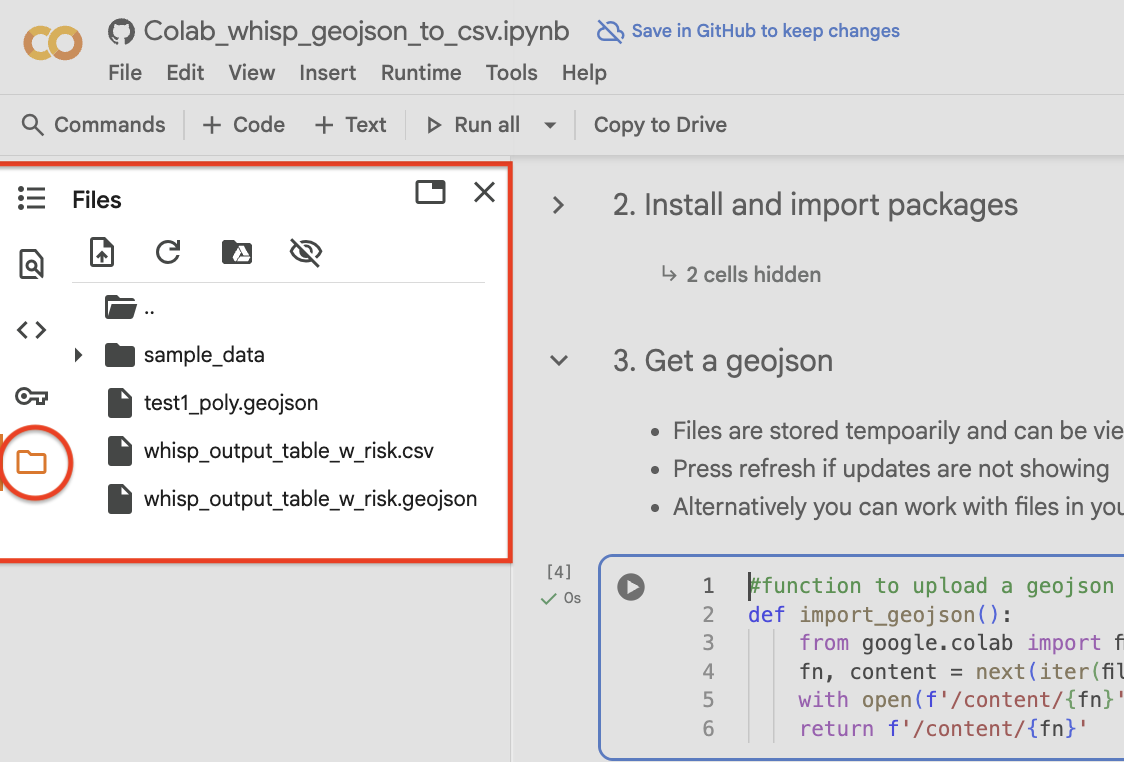
- Press refresh if updates are not showing
- Alternatively you can work with files in your Google Drive: drive.mount('/content/drive')

In [73]:
#function to upload a geojson file. Download example here: https://github.com/andyarnell/whisp/tree/package-test-new-structure/tests/fixtures)
def import_geojson():
    from google.colab import files
    fn, content = next(iter(files.upload().items()))
    with open(f'/content/{fn}', 'wb') as f: f.write(content)
    return f'/content/{fn}'

####3.1. Upload your raw data (geojson to analyze)

In [5]:
GEOJSON_EXAMPLE_FILEPATH = import_geojson()
print(f"GEOJSON_EXAMPLE_FILEPATH: {GEOJSON_EXAMPLE_FILEPATH}")

Saving test1_poly.geojson to test1_poly.geojson
GEOJSON_EXAMPLE_FILEPATH: /content/test1_poly.geojson


###4. Run the WHISP analysis

In [74]:
# Choose countries to process (currently three countries: 'co', 'ci', 'br')
iso2_codes_list = ['co', 'ci', 'br']  # Example ISO2 codes for including country specific data

In [75]:
import ee
import pandas as pd
import geopandas as gpd
import json

# Choose countries to process (currently three countries: 'co', 'ci', 'br')
iso2_codes_list = ['co', 'ci', 'br']  # Example ISO2 codes for including country specific data

# Read the geojson file directly into a GeoDataFrame
gdf = gpd.read_file(GEOJSON_EXAMPLE_FILEPATH)

# Convert any datetime columns to strings in the pandas DataFrame
for col in gdf.columns:
    if pd.api.types.is_datetime64_any_dtype(gdf[col]):
        gdf[col] = gdf[col].astype(str)

# Convert the GeoDataFrame to an Earth Engine FeatureCollection
ee_feature_collection = ee.FeatureCollection(gdf.__geo_interface__)

# Process the Earth Engine FeatureCollection with whisp
df_stats = whisp.whisp_formatted_stats_ee_to_df(
    ee_feature_collection,
    # external_id_column="user_id",# optional - specify which input column/property to map to the external ID.
    national_codes=iso2_codes_list,
    # unit_type='percent', # optional - to change unit type. Default is 'ha'.
    )

Whisp multiband image compiled
Using cached schema for national_codes: ['co', 'ci', 'br']
[reformat.py | log_missing_columns() | l.271] WARNING: The following columns in the schema did not match any columns from the results dataframe: 
external_id


###5.1. Display results - Dataset

In [77]:
df_stats[:5] # This line of code only displays 5 rows. Remove [:5] to visualize the whole content

,plotId,external_id,Area,Geometry_type,Country,ProducerCountry,Admin_Level_1,Centroid_lon,Centroid_lat,Unit,...,nBR_MapBiomas_col9_palmoil_2020,nBR_MapBiomas_col9_pc_2020,nBR_INPE_TCamz_cer_annual_2020,nBR_MapBiomas_col9_soy_2020,nBR_MapBiomas_col9_annual_crops_2020,nBR_INPE_TCamz_pasture_2020,nBR_INPE_TCcer_pasture_2020,nBR_MapBiomas_col9_pasture_2020,nCI_Cocoa_bnetd,geo
0,1,NaN,154.604996,Polygon,COL,CO,Quindío,-75.783744,4.419095,ha,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{'type': 'Polygon', 'coordinates': [[[-75.7912..."
1,2,NaN,27.325001,MultiPolygon,COL,CO,Quindío,-75.780787,4.421473,ha,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{'type': 'Polygon', 'coordinates': [[[-75.7816..."
2,3,NaN,7.255000,Polygon,COL,CO,Quindío,-75.779172,4.419302,ha,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{'type': 'Polygon', 'coordinates': [[[-75.7809..."
3,4,NaN,4.249000,Polygon,COL,CO,Quindío,-75.784319,4.416910,ha,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{'type': 'Polygon', 'coordinates': [[[-75.7853..."
4,5,NaN,6.043000,Polygon,COL,CO,Quindío,-75.787801,4.420453,ha,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"{'type': 'Polygon', 'coordinates': [[[-75.7892..."


####5.1.1 Add risk category columns

In [9]:
# adds risk columns to end of dataframe
df_w_risk = whisp.whisp_risk(df=df_stats,national_codes=iso2_codes_list)

Using unit type: ha


####5.1.2. Display updated table
- Scroll to far right to see additions

In [78]:
df_w_risk[:5] # This line of code only displays 5 rows. Remove [:5] to visualize the whole content

,plotId,external_id,Area,Geometry_type,Country,ProducerCountry,Admin_Level_1,Centroid_lon,Centroid_lat,Unit,...,Ind_05_primary_2020,Ind_06_nat_reg_forest_2020,Ind_07_planted_plantations_2020,Ind_08_planted_plantations_after_2020,Ind_09_treecover_after_2020,Ind_10_agri_after_2020,Ind_11_logging_concession_before_2020,risk_pcrop,risk_acrop,risk_timber
0,1,NaN,154.604996,Polygon,COL,CO,Quindío,-75.783744,4.419095,ha,...,no,yes,no,no,yes,yes,no,low,low,low
1,2,NaN,27.325001,MultiPolygon,COL,CO,Quindío,-75.780787,4.421473,ha,...,no,yes,no,no,yes,yes,no,low,low,low
2,3,NaN,7.255000,Polygon,COL,CO,Quindío,-75.779172,4.419302,ha,...,no,yes,no,no,yes,yes,no,low,low,low
3,4,NaN,4.249000,Polygon,COL,CO,Quindío,-75.784319,4.416910,ha,...,no,yes,no,no,yes,yes,no,low,low,low
4,5,NaN,6.043000,Polygon,COL,CO,Quindío,-75.787801,4.420453,ha,...,no,yes,no,no,yes,yes,no,low,low,low


####5.1.3. Export table with risk columns to CSV & GeoJson (temporary storage)
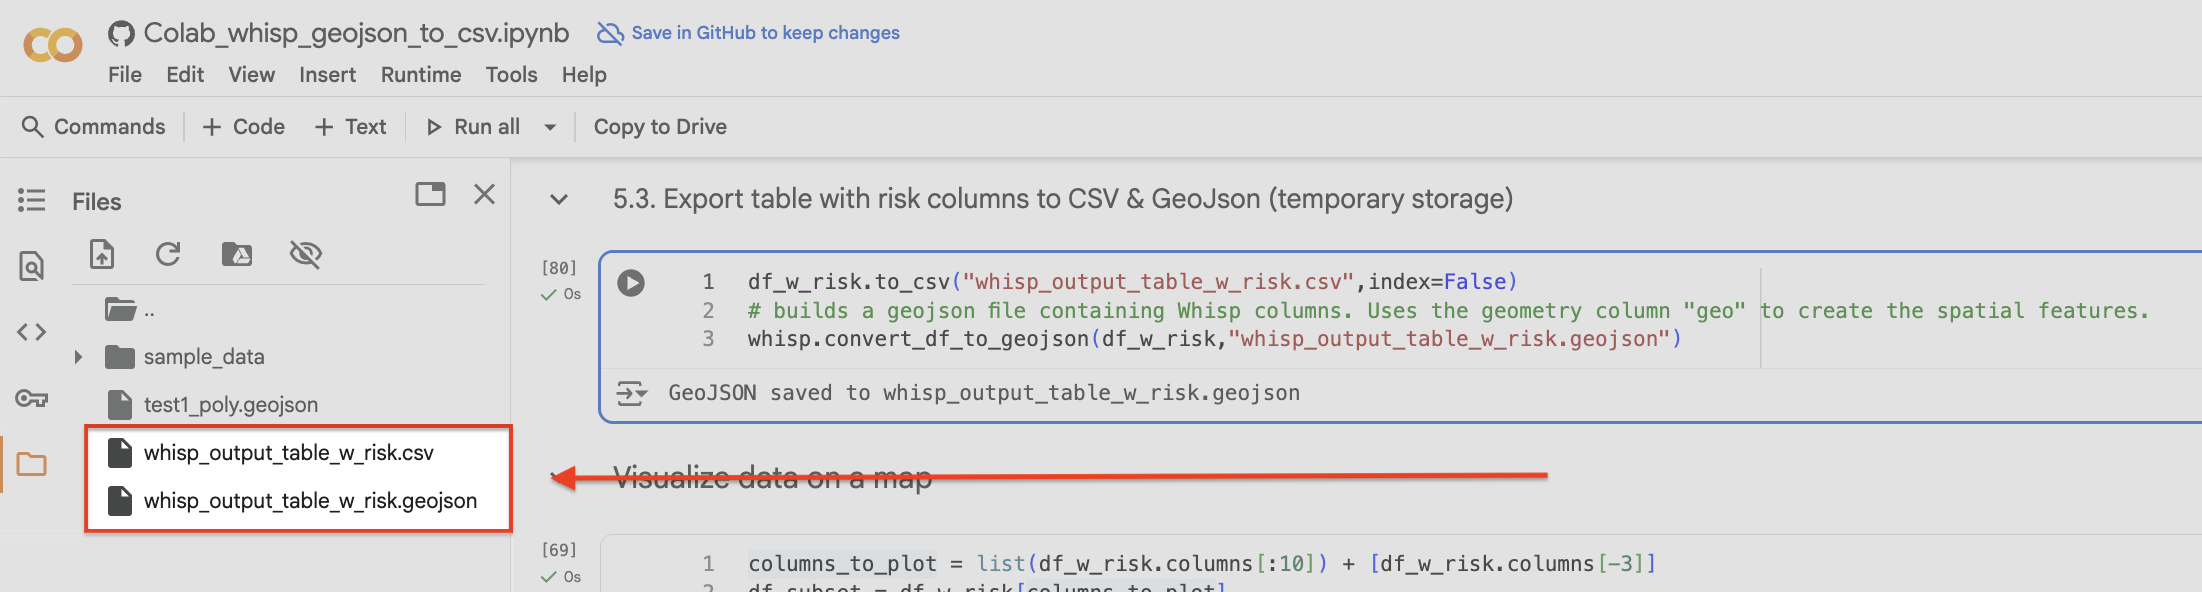

In [80]:
df_w_risk.to_csv("whisp_output_table_w_risk.csv",index=False)
# builds a geojson file containing Whisp columns. Uses the geometry column "geo" to create the spatial features.
whisp.convert_df_to_geojson(df_w_risk,"whisp_output_table_w_risk.geojson")

GeoJSON saved to whisp_output_table_w_risk.geojson


###5.2. Display results - Map

In [82]:
#Data preparation for spatial visualization
columns_to_plot = list(df_w_risk.columns[:10]) + [df_w_risk.columns[-3]]
df_subset = df_w_risk[columns_to_plot]
df_subset[:5] # This line of code only displays 5 rows. Remove [:5] to visualize the whole content

,plotId,external_id,Area,Geometry_type,Country,ProducerCountry,Admin_Level_1,Centroid_lon,Centroid_lat,Unit,risk_pcrop
0,1,NaN,154.604996,Polygon,COL,CO,Quindío,-75.783744,4.419095,ha,low
1,2,NaN,27.325001,MultiPolygon,COL,CO,Quindío,-75.780787,4.421473,ha,low
2,3,NaN,7.255000,Polygon,COL,CO,Quindío,-75.779172,4.419302,ha,low
3,4,NaN,4.249000,Polygon,COL,CO,Quindío,-75.784319,4.416910,ha,low
4,5,NaN,6.043000,Polygon,COL,CO,Quindío,-75.787801,4.420453,ha,low


In [92]:
import folium

# Load your polygons (must be GeoJSON or shapefile converted to GeoDataFrame)
gdf = gpd.read_file("whisp_output_table_w_risk.geojson")  # call the geojson file you temporarly saved in the previous snippet

# Compute centroids
gdf["centroid"] = gdf.geometry.centroid

# Get the average center of your data for initial map zoom
map_center = [gdf.centroid.y.mean(), gdf.centroid.x.mean()]

# Create base map (default dark)
m = folium.Map(location=map_center, zoom_start=14, tiles=None)

# Add dark basemap
folium.TileLayer('CartoDB dark_matter', name='Dark').add_to(m)

# Add light basemap
folium.TileLayer('CartoDB positron', name='Light').add_to(m)

# Create FeatureGroups
polygon_layer = folium.FeatureGroup(name="Polygons")
centroid_layer = folium.FeatureGroup(name="Centroids")

# Add polygons (risk areas)
folium.GeoJson(
    gdf.drop(columns=['centroid']),  # exclude centroid from GeoJson
    name="Polygons",
    style_function=lambda x: {
        "fillColor": "lightgray",
        "color": "darkgray",
        "weight": 1,
        "fillOpacity": 0.3,
    }
).add_to(polygon_layer)

# Define color mapping for risk categories
color_map = {
    "low": "green",
    "more_info_needed": "orange",
    "high": "red"
}

# Add centroids colored by pcrop_risk
for _, row in gdf.iterrows():
    risk_cat = row.get("risk_pcrop", "more_info_needed")
    color = color_map.get(str(risk_cat).lower(), "gray")  # default gray if missing

    folium.CircleMarker(
        location=[row["centroid"].y, row["centroid"].x],
        radius=6,
        color=color,
        fill=True,
        fill_opacity=0.9,
        popup=f"Pcrop Risk: {risk_cat}"
    ).add_to(centroid_layer)

# Add layers to the map
polygon_layer.add_to(m)
centroid_layer.add_to(m)

# Add legend
legend_html = """
<div style="position: fixed;
     bottom: 30px; left: 30px; width: 140px; height: 130px;
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; padding: 5px;">
<b>Pcrop Risk</b><br>
<i style="background:green; width:10px; height:10px; float:left; margin-right:5px;"></i> Low<br>
<i style="background:orange; width:10px; height:10px; float:left; margin-right:5px;"></i> More info needed<br>
<i style="background:red; width:10px; height:10px; float:left; margin-right:5px;"></i> High<br>
<i style="background:gray; width:10px; height:10px; float:left; margin-right:5px;"></i> Unknown
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Add layer control
folium.LayerControl().add_to(m)

# Save the map to HTML
m.save("whisp_risk_map.html")

# Show interactive map
m


/tmp/ipython-input-3864117614.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["centroid"] = gdf.geometry.centroid
/tmp/ipython-input-3864117614.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  map_center = [gdf.centroid.y.mean(), gdf.centroid.x.mean()]


###6. Download outputs to local storage
- Saves files in "Downloads" folder on your machine
- If you see a "Downloads blocked" button at top of browser click to allow file downloads.
- Alternatively right click on file in the folder (in the panel on your left) and choose 'Download'.

In [93]:
from google.colab import files
files.download('whisp_output_table_w_risk.csv')

# spatial output
files.download('whisp_output_table_w_risk.geojson')

# Map in html format
files.download("whisp_risk_map.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>